In [1]:
import numpy as np
import pandas as pd
import openturns as ot
import seaborn as sns
import copulogram as cp
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba
from bancs import BANCS

In [2]:
ot.ResourceMap.SetAsUnsignedInteger('KernelSmoothing-BinNumber', 1000)

In [3]:
f = ot.SymbolicFunction(["x1", "x2", "x3"],
    ["sin(x1) / (1 + cos(x1)^2) + 0.05 * x2", 
     "sin(x1) * cos(x1) / (1 + cos(x1)^2) + 0.05 * x3"],
)
X = ot.Normal(3)
N = int(1e6)
x_sample = X.getSample(N)
x_sample.setDescription(["x1", "x2", "x3"])
y_sample = f(x_sample)
y_sample.setDescription(["y1", "y2"])

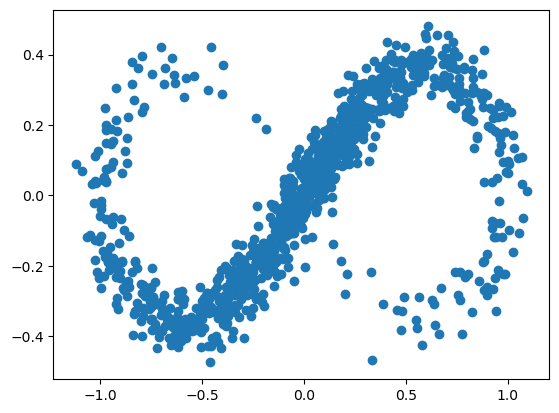

In [4]:
plt.scatter(y_sample[:1000, 0], y_sample[:1000, 1]);

In [5]:
x_sample.stack(y_sample)
df = pd.DataFrame(np.array(x_sample), columns=list(x_sample.getDescription()))
df["y"] = df["y1"] + df["y2"]
df["failed"] = 0
df.loc[(df["y1"]<-0.3) & (df["y2"]>0.3), "failed"] = 1

In [6]:
color_palette = sns.color_palette([to_rgba('C2', 0.3), to_rgba('C3', 0.9)], as_cmap=True)

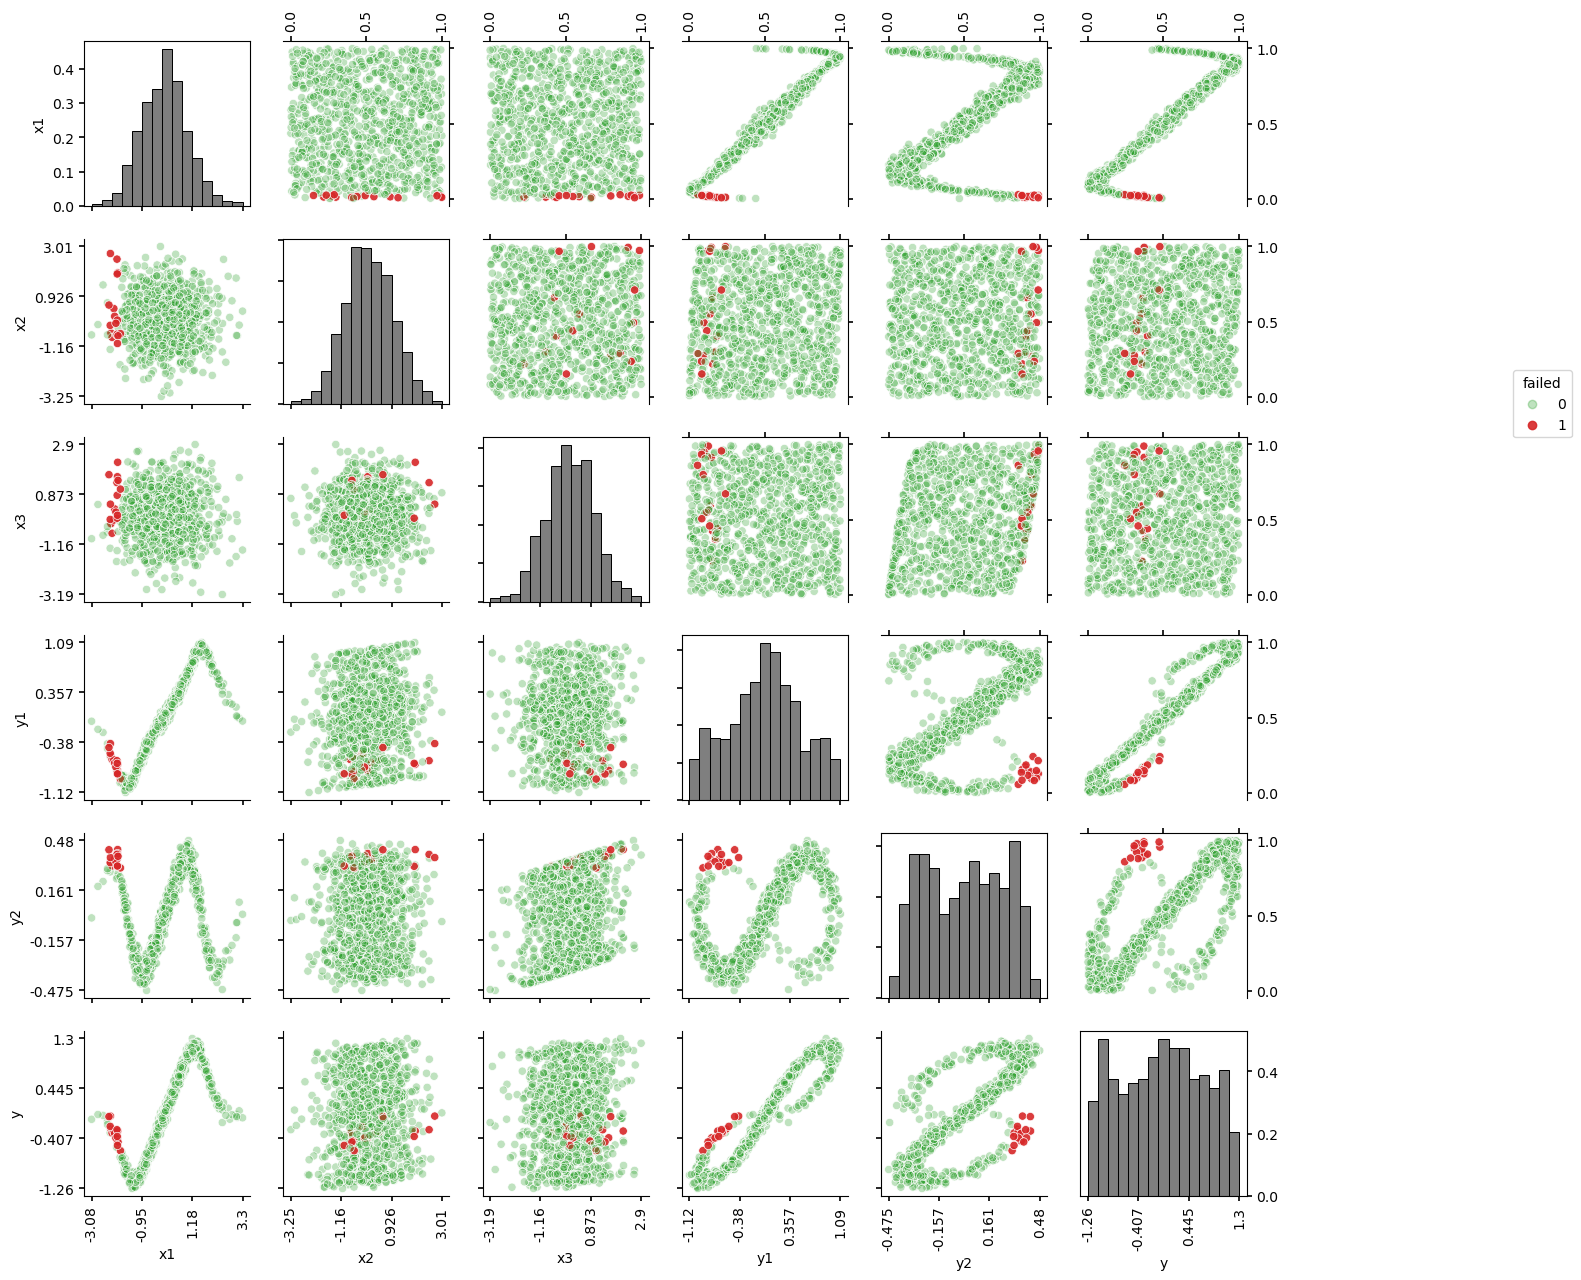

In [7]:
copulogram = cp.Copulogram(df.loc[:1000, :])
copulogram.draw(hue="failed", hue_colorbar=color_palette);

In [8]:
#MC reference 
df['failed'].mean()

0.017387

In [9]:
g = ot.SymbolicFunction(["x1", "x2", "x3"], ["sin(x1) / (1 + cos(x1)^2) + 0.05 * x2 - sin(x1) * cos(x1) / (1 + cos(x1)^2) + 0.05 * x3"])
Y = ot.CompositeRandomVector(g, ot.RandomVector(X))
threshold = -0.5
failure_event = ot.ThresholdEvent(Y, ot.LessOrEqual(), threshold)

In [10]:
experiment = ot.MonteCarloExperiment()
algo = ot.ProbabilitySimulationAlgorithm(failure_event, experiment)
algo.setMaximumOuterSampling(int(1e6))
algo.setMaximumCoefficientOfVariation(-1.0)
algo.setBlockSize(1)
algo.run()
res = algo.getResult()
print(res.getOuterSampling())
print('Probability estimate=%.6f' % res.getProbabilityEstimate())

1000000
Probability estimate=0.115328


In [11]:
n = int(1e4)
m = 50
bancs = BANCS(failure_event, N=n, M=m, p0=0.1)
_ = bancs.run()
pf = bancs.compute_pf()
pf

0.1155

In [12]:
ss = ot.SubsetSampling(failure_event, 0.1)
ss.setMaximumOuterSampling(n)
ss.run()
res = ss.getResult()
pf = res.getProbabilityEstimate()
pf

0.1154